In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

Using TensorFlow backend.


# Distance trainer

In [2]:
import pickle

with open('bounding_box_coordinates.pickle', 'rb') as handle:
    X = pickle.load(handle)
    
with open('distances.pickle', 'rb') as handle:
    y = pickle.load(handle)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [4]:
model_distance = Sequential()
model_distance.add(Dense(32, input_dim=4, activation='relu'))
model_distance.add(Dense(32, activation='relu'))
model_distance.add(Dense(1))

model_distance.compile(optimizer='adam',
                       loss='mse')

In [5]:
model_distance.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Train on 3381 samples, validate on 376 samples
Epoch 1/100
3381/3381 [==============================] - 2s - loss: 40.4920 - val_loss: 20.5205
Epoch 2/100
3381/3381 [==============================] - 0s - loss: 5.4221 - val_loss: 2.5454
Epoch 3/100
3381/3381 [==============================] - 0s - loss: 2.4158 - val_loss: 2.5323
Epoch 4/100
3381/3381 [==============================] - 0s - loss: 2.4038 - val_loss: 2.5166
Epoch 5/100
3381/3381 [==============================] - 0s - loss: 2.3905 - val_loss: 2.4973
Epoch 6/100
3381/3381 [==============================] - 0s - loss: 2.3788 - val_loss: 2.5282
Epoch 7/100
3381/3381 [==============================] - 0s - loss: 2.3665 - val_loss: 2.5324
Epoch 8/100
3381/3381 [==============================] - 0s - loss: 2.3498 - val_loss: 2.4416
Epoch 9/100
3381/3381 [==============================] - 0s - loss: 2.3287 - val_loss: 2.4324
Epoch 10/100
3381/3381 [==============================] - 0s - loss: 2.3123 - val_loss: 2.4391
Epoch 11/1

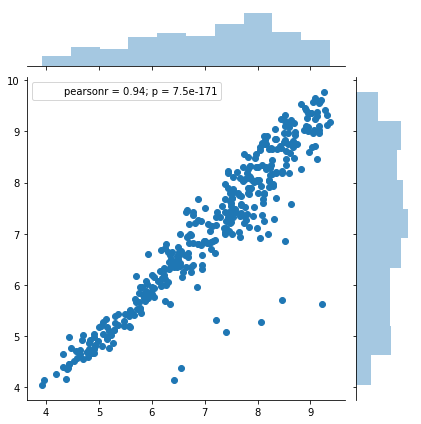

In [6]:
import seaborn as sns
sns.jointplot(model_distance.predict(X_test), y_test)

In [7]:
model_distance.save('model/model_distance.h5')

# Direction trainer

In [2]:
import keras.backend as K
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Lambda

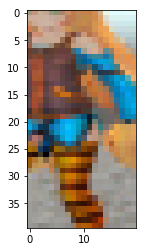

In [8]:
import cv2

IMG_SIZE = (20,40)

img = cv2.imread('human_imgs/0_5281.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, IMG_SIZE)
plt.imshow(img)

In [9]:
print(img.shape)
print(img/255)

(40, 20, 3)
[[[ 0.60784314  0.60784314  0.50196078]
  [ 0.76078431  0.59215686  0.49411765]
  [ 0.77647059  0.69411765  0.59215686]
  ..., 
  [ 0.85882353  0.98823529  1.        ]
  [ 0.90196078  0.98431373  0.96862745]
  [ 0.87843137  0.98823529  0.99607843]]

 [[ 0.79215686  0.67843137  0.60392157]
  [ 0.80784314  0.67843137  0.62745098]
  [ 0.80392157  0.69803922  0.60392157]
  ..., 
  [ 0.85882353  0.94117647  0.94901961]
  [ 0.84705882  0.94901961  0.95294118]
  [ 0.84705882  0.94901961  0.95294118]]

 [[ 0.77647059  0.59215686  0.44313725]
  [ 0.79215686  0.6627451   0.56470588]
  [ 0.78823529  0.69803922  0.64313725]
  ..., 
  [ 0.79215686  0.91372549  0.92156863]
  [ 0.79215686  0.91372549  0.92156863]
  [ 0.81176471  0.90588235  0.91372549]]

 ..., 
 [[ 0.61568627  0.61176471  0.59607843]
  [ 0.61960784  0.61568627  0.6       ]
  [ 0.63137255  0.63137255  0.61176471]
  ..., 
  [ 0.60392157  0.61568627  0.56862745]
  [ 0.57647059  0.58823529  0.55294118]
  [ 0.58039216  0.56862

In [10]:
imgs = []
angles = []
directions = []
import os
import numpy as np

angle_thr = 30
for jpg in os.listdir('human_imgs/'):
    img = cv2.imread('human_imgs/'+jpg)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img/255
    imgs += [img[np.newaxis, :]]
    angle = int(jpg.split('_')[0])
    angles += [angle]
    direction = np.zeros((4))
    if angle > angle_thr and angle < 180 - angle_thr:
        direction[3] = 1
    elif angle > 180 + angle_thr and angle < 360 - angle_thr:
        direction[1] = 1
    if angle > 90 + angle_thr and angle < 270 - angle_thr:
        direction[0] = 1
    elif angle < 90 - angle_thr or angle > 270 + angle_thr:
        direction[2] = 1
    directions += [direction]

In [11]:
imgs = np.vstack(imgs)
angles = np.vstack(angles)
directions = np.vstack(directions)
print(imgs.shape)
print(angles.shape)
print(directions.shape)

(9654, 40, 20, 3)
(9654, 1)
(9654, 4)


In [12]:
img_train, img_test, angle_train, angle_test, direction_train, direction_test = train_test_split(imgs, angles, directions, test_size=0.1)

In [30]:
model_direction = Sequential()
model_direction.add(Conv2D(64, (5,5), strides=(1,1), padding='same', input_shape=(40, 20, 3)))
model_direction.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_direction.add(BatchNormalization(axis=-1))

model_direction.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
model_direction.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_direction.add(BatchNormalization(axis=-1))

model_direction.add(Conv2D(256, (3,3), strides=(1,1), padding='same'))
model_direction.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_direction.add(BatchNormalization(axis=-1))

model_direction.add(Flatten())
model_direction.add(Dense(512, activation='relu'))
model_direction.add(Dropout(0.5))
model_direction.add(Dense(1024, activation='relu'))
model_direction.add(Dropout(0.5))
model_direction.add(Dense(4, activation='sigmoid'))

model_direction.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 40, 20, 64)        4864      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 10, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 10, 64)        256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 10, 5, 128)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 10, 5, 128)        512       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 5, 256)        295168    
__________

In [32]:
model_direction.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
model_direction.fit(img_train, direction_train, epochs=10, batch_size=128, validation_data=(img_test, direction_test))

Train on 8688 samples, validate on 966 samples
Epoch 1/10
8688/8688 [==============================] - 2s - loss: 0.0498 - acc: 0.9822 - val_loss: 0.1476 - val_acc: 0.9542
Epoch 2/10
8688/8688 [==============================] - 1s - loss: 0.0480 - acc: 0.9823 - val_loss: 0.1625 - val_acc: 0.9568
Epoch 3/10
8688/8688 [==============================] - 1s - loss: 0.0392 - acc: 0.9866 - val_loss: 0.1643 - val_acc: 0.9638
Epoch 4/10
8688/8688 [==============================] - 1s - loss: 0.0323 - acc: 0.9883 - val_loss: 0.1418 - val_acc: 0.9656
Epoch 5/10
8688/8688 [==============================] - 1s - loss: 0.0262 - acc: 0.9904 - val_loss: 0.1529 - val_acc: 0.9689
Epoch 6/10
8688/8688 [==============================] - 1s - loss: 0.0246 - acc: 0.9909 - val_loss: 0.2478 - val_acc: 0.9441
Epoch 7/10
8688/8688 [==============================] - 1s - loss: 0.0224 - acc: 0.9917 - val_loss: 0.3121 - val_acc: 0.9273
Epoch 8/10
8688/8688 [==============================] - 1s - loss: 0.0261 - ac

In [36]:
model_direction.save_weights('model/model_direction_lowres_weights.h5')

## Load model

In [ ]:
model_direction.load_weights('model/model_direction_weights.h5')

In [33]:
preds = model_direction.predict(img_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [34]:
from sklearn.metrics import f1_score

f1_score(direction_test, preds, average=None)

array([ 0.96706587,  0.96482412,  0.95547945,  0.96176471])

In [35]:
print(preds[:10])
print(angle_test[:10])

[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 0.  0.  1.  1.]
 [ 1.  0.  0.  1.]]
[[ 75]
 [106]
 [159]
 [176]
 [ 14]
 [253]
 [142]
 [133]
 [ 47]
 [129]]


# Test resnet

In [48]:
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt

def _bn_relu(inputs):
    """
    BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(inputs)
    return Activation("relu")(norm)

def _conv_bn_relu(filters, kernel_size=(3, 3), strides=(1, 1)):
    """
    conv -> BN -> relu
    """
    def f(inputs):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                      padding='same', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
        norm = BatchNormalization(axis=CHANNEL_AXIS)(conv)
        return Activation("relu")(norm)
    return f

def _bn_relu_conv(filters, kernel_size=(3, 3), strides=(1, 1)):
    """
    BN -> relu -> conv
    """
    def f(inputs):
        norm = BatchNormalization(axis=CHANNEL_AXIS)(inputs)
        activation = Activation("relu")(norm)
        return Conv2D(filters=filters, kernel_size=kernel_size, strides=strides,
                      padding='same', kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(activation)
    return f

def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """
    basic residual block : 3*3 kernel
    """
    def f(inputs):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(inputs)
        else:
            conv1 = _bn_relu_conv(filters, (3, 3), strides=init_strides)(inputs)
        residual = _bn_relu_conv(filters, (3, 3))(conv1)
        return _shortcut(inputs, residual)
    return f

def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """
    bottleneck : 1*1 filters -> 3*3 filters -> 1*1 4*filters
    """
    def f(inputs):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(inputs)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(inputs)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(inputs, residual)
    return f

def _shortcut(inputs, residual):
    input_shape = K.int_shape(inputs)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = residual._keras_shape[CHANNEL_AXIS] == inputs._keras_shape[CHANNEL_AXIS]

    shortcut = inputs
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual._keras_shape[CHANNEL_AXIS], kernel_size=(1, 1), strides=(stride_width, stride_height),
                          padding="valid", kernel_initializer="he_normal")(inputs)

    return add([shortcut, residual])

def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    def f(inputs):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            inputs = block_function(filters=filters, init_strides=init_strides,
                                    is_first_block_of_first_layer=(is_first_layer and i == 0))(inputs)
        return inputs
    return f


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_rows, nb_cols, nb_channels)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        assert input_shape[-1] == 3, 'must use channel_last format!'
        global ROW_AXIS, COL_AXIS, CHANNEL_AXIS
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
        
        inputs = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(inputs)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal", activation='sigmoid')(flatten1)

        model = Model(inputs=inputs, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [49]:
model_res = ResnetBuilder.build_resnet_18(img_train[0].shape, 4)
model_res.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [50]:
model_res.fit(img_train, direction_train, epochs=10, batch_size=32, validation_data=(img_test, direction_test))

Train on 8688 samples, validate on 966 samples
Epoch 1/10
8688/8688 [==============================] - 17s - loss: 0.4669 - acc: 0.9403 - val_loss: 0.4608 - val_acc: 0.8929
Epoch 2/10
8688/8688 [==============================] - 14s - loss: 0.2218 - acc: 0.9609 - val_loss: 0.6278 - val_acc: 0.8300
Epoch 3/10
8688/8688 [==============================] - 13s - loss: 0.1661 - acc: 0.9678 - val_loss: 3.2019 - val_acc: 0.5828
Epoch 4/10
8688/8688 [==============================] - 14s - loss: 0.1442 - acc: 0.9699 - val_loss: 1.9427 - val_acc: 0.6928
Epoch 5/10
8688/8688 [==============================] - 14s - loss: 0.1331 - acc: 0.9726 - val_loss: 0.1696 - val_acc: 0.9565
Epoch 6/10
8688/8688 [==============================] - 13s - loss: 0.1195 - acc: 0.9743 - val_loss: 0.1709 - val_acc: 0.9578
Epoch 7/10
8688/8688 [==============================] - 13s - loss: 0.1060 - acc: 0.9783 - val_loss: 1.2767 - val_acc: 0.7953
Epoch 8/10
8688/8688 [==============================] - 14s - loss: 0.1

In [51]:
preds = model_res.predict(img_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [52]:
f1_score(direction_test, preds, average=None)

array([ 0.93623188,  0.95718654,  0.88848263,  0.94930876])

In [22]:
model_res.save_weights('model/model_direction_res18_weights.h5')